In [5]:
!pip install transformers datasets lxml tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import BartTokenizer, BartForConditionalGeneration
import matplotlib.pyplot as plt
from pathlib import Path

# パラメータ設定
BATCH_SIZE = 4
EPOCHS = 5
EMBED_DIM = 768  # BARTのエンコーダ次元
NUM_HEADS = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAMBDA_INIT = 0.5  # 初期値

# ディレクトリの設定
base_dir = Path("/content/drive/MyDrive/Colab Notebooks")
data_dir = base_dir / "data"
weights_dir = base_dir / "weights"

# ディレクトリ作成
data_dir.mkdir(parents=True, exist_ok=True)
weights_dir.mkdir(parents=True, exist_ok=True)

# データの保存・読み込み処理
def prepare_or_load_data(data_dir, tokenizer, split="train[:25%]", dataset_name="cnn_dailymail", version="3.0.0"):
    data_path = data_dir / "prepared_cnn_dailymail_data.pt"
    if data_path.exists():
        print(f"Loading dataset from {data_path}")
        data = torch.load(data_path)
    else:
        print("Downloading and preparing dataset...")
        dataset = load_dataset(dataset_name, version, split=split)

        def tokenize_data(example):
            return tokenizer(example["article"], max_length=512, truncation=True, padding="max_length")

        dataset = dataset.map(tokenize_data, batched=True)
        dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
        torch.save(dataset, data_path)
        print(f"Dataset saved to {data_path}")
        data = dataset
    return data

# トークナイザーとデータの準備
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
dataset = prepare_or_load_data(data_dir, tokenizer)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Multi-Head Diff Attention
class MultiHeadDiffAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, lambda_init=0.5):
        super(MultiHeadDiffAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim)

        self.lambda_ = nn.Parameter(torch.tensor(lambda_init))

    def forward(self, X, attention_mask=None):
        B, N, D = X.shape
        H = self.num_heads

        Q = self.W_q(X).view(B, N, H, self.head_dim).transpose(1, 2)  # (B, H, N, head_dim)
        K = self.W_k(X).view(B, N, H, self.head_dim).transpose(1, 2)  # (B, H, N, head_dim)
        V = self.W_v(X).view(B, N, H, self.head_dim).transpose(1, 2)  # (B, H, N, head_dim)

        scale = self.head_dim ** -0.5

        # スコア計算
        Q1, Q2 = torch.chunk(Q, 2, dim=-1)  # 分割 (B, H, N, head_dim // 2)
        K1, K2 = torch.chunk(K, 2, dim=-1)

        A1 = F.softmax(torch.matmul(Q1, K1.transpose(-2, -1)) * scale, dim=-1)  # (B, H, N, N)
        A2 = F.softmax(torch.matmul(Q2, K2.transpose(-2, -1)) * scale, dim=-1)

        diff_attention = A1 - self.lambda_ * A2
        attn_output = torch.matmul(diff_attention, V)  # (B, H, N, head_dim)

        attn_output = attn_output.transpose(1, 2).contiguous().view(B, N, D)  # (B, N, D)
        output = self.W_o(attn_output)  # (B, N, D)

        return output, A1, A2, diff_attention


class BartWithMultiHeadDiffAttention(nn.Module):
    def __init__(self, model_name="facebook/bart-base", embed_dim=768, num_heads=8, lambda_init=0.5):
        super(BartWithMultiHeadDiffAttention, self).__init__()
        self.bart = BartForConditionalGeneration.from_pretrained(model_name)
        self.multihead_diff_attention = MultiHeadDiffAttention(embed_dim, num_heads, lambda_init)

        for param in self.bart.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        encoder_outputs = self.bart.model.encoder(input_ids, attention_mask=attention_mask)
        custom_output, A1, A2, diff_attention = self.multihead_diff_attention(
            encoder_outputs.last_hidden_state, attention_mask
        )
        encoder_outputs.last_hidden_state = custom_output
        decoder_outputs = self.bart.model.decoder(
            input_ids=decoder_input_ids,
            encoder_hidden_states=encoder_outputs.last_hidden_state,
            encoder_attention_mask=attention_mask,
        )
        logits = self.bart.lm_head(decoder_outputs.last_hidden_state)
        return logits, A1, A2, diff_attention


model = BartWithMultiHeadDiffAttention(num_heads=NUM_HEADS, lambda_init=LAMBDA_INIT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

def train_model(model, optimizer, train_loader, device, epochs, weights_dir):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            decoder_input_ids = torch.cat(
                [torch.full((input_ids.size(0), 1), tokenizer.bos_token_id, dtype=torch.long).to(device), input_ids[:, :-1]], dim=-1
            )
            labels = input_ids

            optimizer.zero_grad()
            logits, _, _, _ = model(input_ids, attention_mask, decoder_input_ids)
            loss = criterion(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    model_path = weights_dir / "model_weights.pt"
    torch.save(model.state_dict(), model_path)
    print(f"Model weights saved to {model_path}")
    return losses

def plot_losses(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses) + 1), losses, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid()
    plt.show()

losses = train_model(model, optimizer, train_loader, DEVICE, EPOCHS, weights_dir)
plot_losses(losses)

In [59]:
def load_and_predict(weights_dir, model, tokenizer, sample_text, device):
    model_path = weights_dir / "model_weights.pt"
    if model_path.exists():
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        print(f"Model weights loaded from {model_path}")
    else:
        print("No saved model weights found. Please train the model first.")
        return

    model.eval()
    tokens = tokenizer(sample_text, return_tensors="pt", truncation=True, max_length=512, padding="max_length").to(device)
    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    # 初期デコーダ入力トークン
    decoder_input_ids = torch.tensor([[tokenizer.bos_token_id]], device=device)

    # 最大生成長
    max_length = 50
    generated_tokens = decoder_input_ids

    with torch.no_grad():
        for _ in range(max_length):
            # 推論
            output = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=generated_tokens)
            logits = output[0]

            # 次のトークンを予測
            next_token_id = torch.argmax(logits[:, -1, :], dim=-1).unsqueeze(0)

            # 次のトークンを生成済みトークンに追加
            generated_tokens = torch.cat([generated_tokens, next_token_id], dim=-1)

            # 終了トークン（EOS）を検出したら終了
            if next_token_id.item() == tokenizer.eos_token_id:
                break

    # トークン列をデコード
    prediction = tokenizer.decode(generated_tokens[0].tolist(), skip_special_tokens=True)
    print(f"Predicted summary: {prediction}")
# サンプルテキストで推論
sample_text = "AI will play an important role in future technological developments, including natural language. cute cats."
load_and_predict(weights_dir, model, tokenizer, sample_text, DEVICE)
# Predicted summary: AI will help us in future developments, including natural language evolution.

Model weights loaded from /content/drive/MyDrive/Colab Notebooks/weights/model_weights.pt
Predicted summary: AI will help us in future developments, including natural language evolution.


Model weights loaded from /content/drive/MyDrive/Colab Notebooks/weights/model_weights.pt
Learned λ value: 0.463478684425354


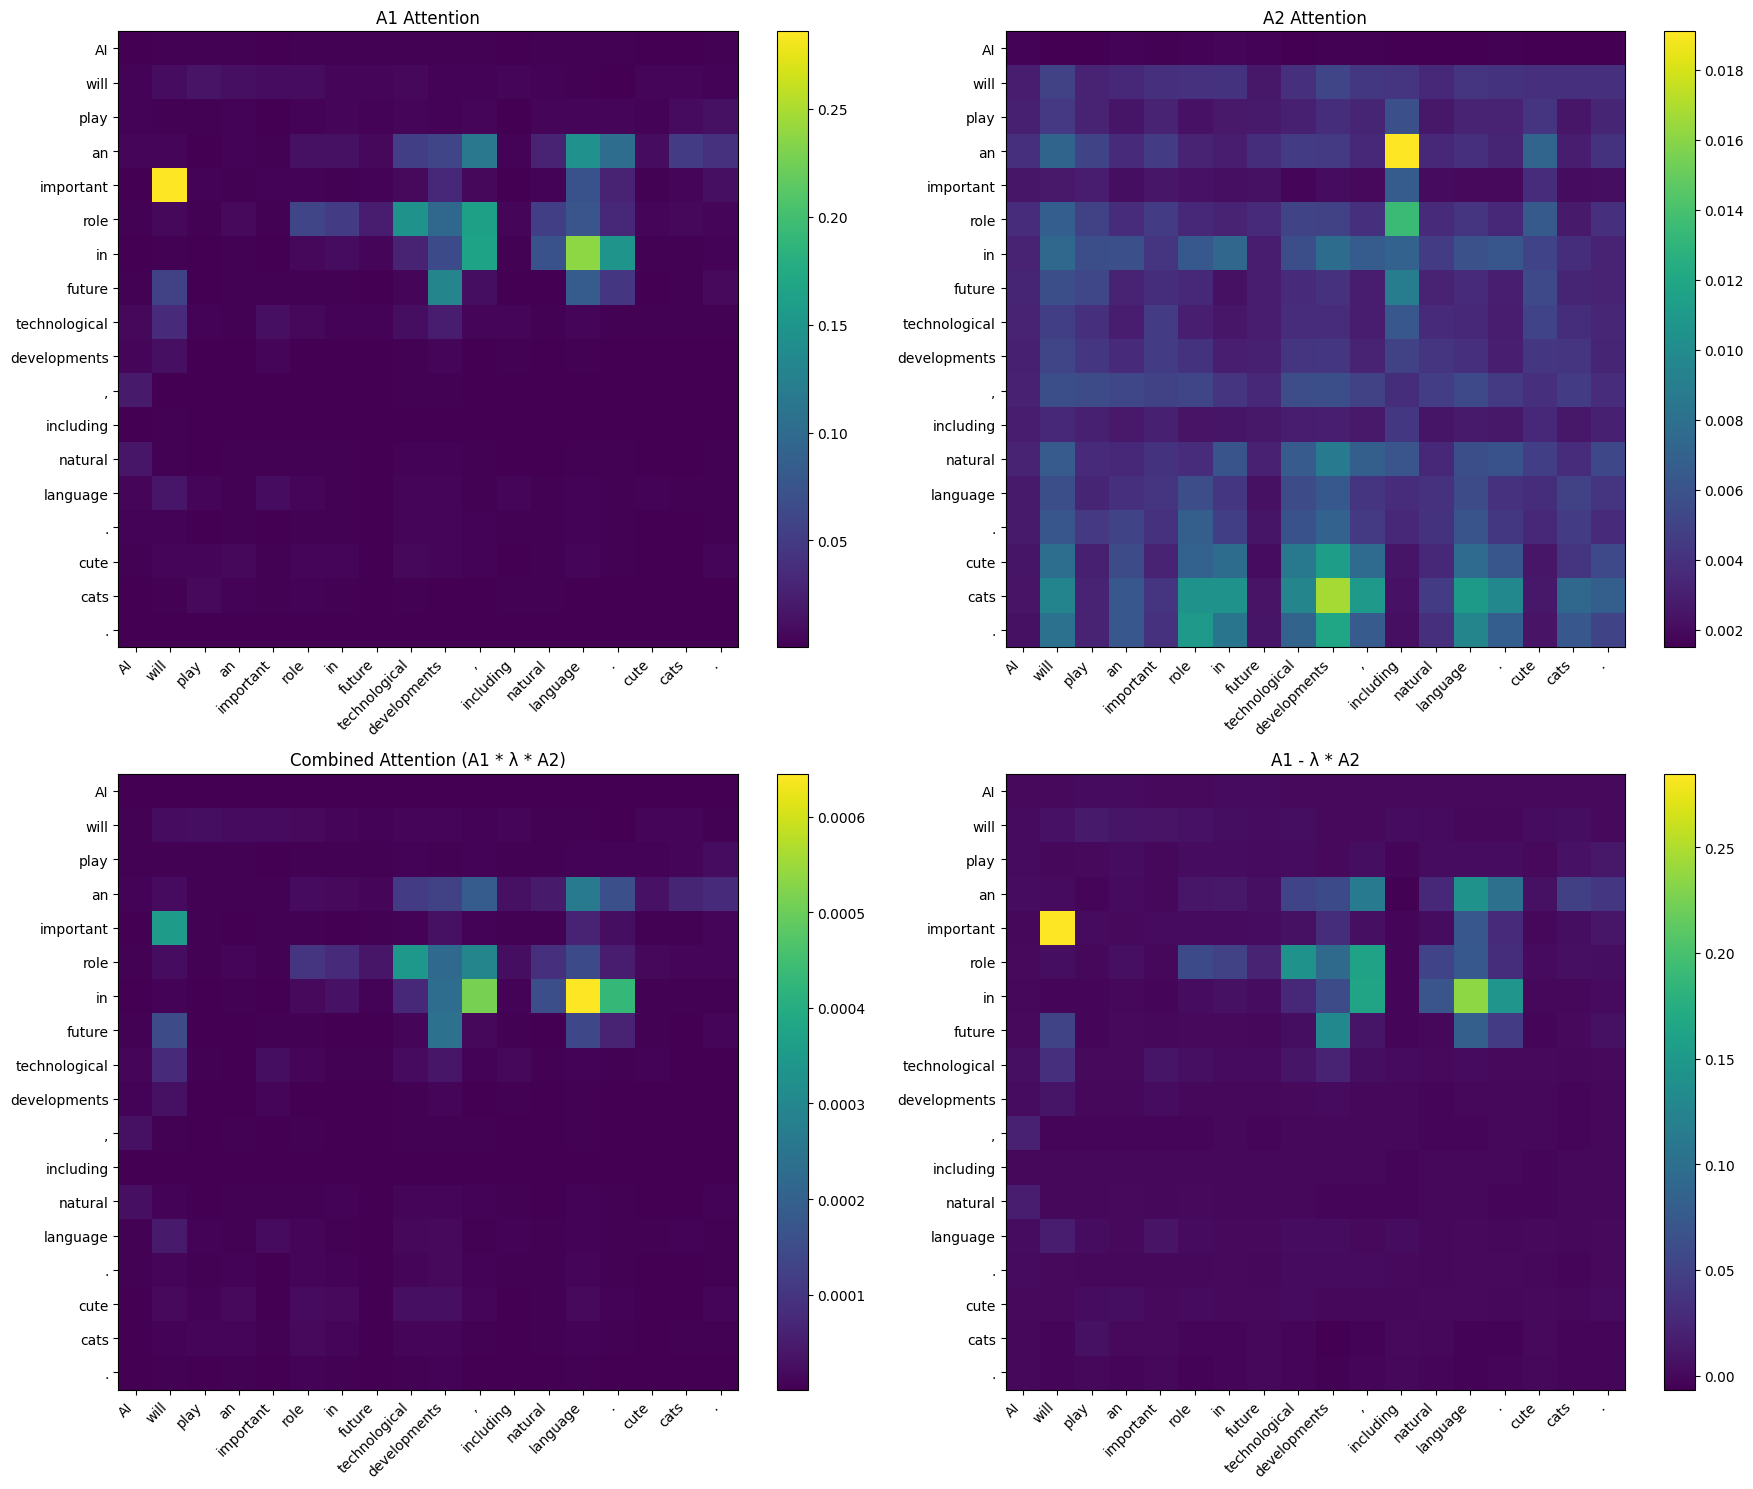

In [65]:
def filter_pad_tokens(attention_map, tokens):
    """
    Filters out <PAD> tokens from the attention map and tokens.
    """
    valid_indices = [i for i, token in enumerate(tokens) if token != "<pad>"]
    return attention_map[:, valid_indices][valid_indices, :], [tokens[i] for i in valid_indices]

def visualize_attention_map_no_normalization(A1, A2, lambda_value, input_tokens):
    """
    Visualize the attention maps for A1, A2, and their interactions (No Normalization).
    """
    # Compute mean attention and scaled values
    A1_mean = A1.mean(dim=1)[0].cpu().numpy()
    A2_mean = A2.mean(dim=1)[0].cpu().numpy()
    scaled_A2 = lambda_value * A2_mean

    # A1, A2, and interactions
    combined_attention = A1_mean * scaled_A2
    diff_map = A1_mean - scaled_A2

    # Filter out <PAD> tokens
    A1_mean, input_tokens = filter_pad_tokens(A1_mean, input_tokens)
    A2_mean, _ = filter_pad_tokens(A2_mean, input_tokens)
    combined_attention, _ = filter_pad_tokens(combined_attention, input_tokens)
    diff_map, _ = filter_pad_tokens(diff_map, input_tokens)

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(18, 15))
    titles = ["A1 Attention", "A2 Attention",
              "Combined Attention (A1 * λ * A2)", "A1 - λ * A2"]
    data = [A1_mean, A2_mean, combined_attention, diff_map]

    for ax, title, attention in zip(axes.flatten(), titles, data):
        im = ax.imshow(attention, cmap="viridis", aspect="auto")
        ax.set_title(title)
        ax.set_xticks(range(len(input_tokens)))
        ax.set_xticklabels(input_tokens, rotation=45, ha="right", fontsize=10)
        ax.set_yticks(range(len(input_tokens)))
        ax.set_yticklabels(input_tokens, fontsize=10)
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

def clean_tokens(input_tokens):
    """
    Cleans up a list of tokens by removing the "Ġ" prefix and unnecessary special tokens.
    """
    return [token[1:] if token.startswith("Ġ") else token for token in input_tokens if token not in {"<pad>", "</s>", "<s>", ""}]

def get_attention_maps_and_lambda(weights_dir, model, tokenizer, sample_text, device):
    """
    Loads the model and computes the attention maps and lambda value.
    """
    model_path = weights_dir / "model_weights.pt"
    if not model_path.exists():
        print("No saved model weights found. Please train the model first.")
        return None, None, None, None

    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    print(f"Model weights loaded from {model_path}")

    model.eval()
    try:
        learned_lambda = model.multihead_diff_attention.lambda_.item()
        print(f"Learned λ value: {learned_lambda}")
    except AttributeError as e:
        print("Error: The model does not have a 'lambda_' attribute in 'multihead_diff_attention'.")
        raise e

    tokens = tokenizer(sample_text, return_tensors="pt", truncation=True, max_length=512, padding="max_length").to(device)
    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]
    decoder_input_ids = torch.tensor([[tokenizer.bos_token_id]], device=device)

    with torch.no_grad():
        logits, A1, A2, diff_attention = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids)

    input_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    return A1, A2, learned_lambda, input_tokens

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights_dir = Path("/content/drive/MyDrive/Colab Notebooks/weights")
sample_text = "AI will play an important role in future technological developments, including natural language. cute cats."

A1, A2, learned_lambda, input_tokens = get_attention_maps_and_lambda(weights_dir, model, tokenizer, sample_text, device)
if A1 is not None and A2 is not None and learned_lambda is not None:
    visualize_attention_map_no_normalization(A1, A2, learned_lambda, clean_tokens(input_tokens))

In [70]:
def visualize_attention_with_model_lambda(weights_dir, model, tokenizer, sample_text, device, max_length=512):
    """
    モデルから λ を取得し、A1, λ * A2 の共通Attention単語をWord Cloudで表示
    """
    # モデルのロード
    model_path = weights_dir / "model_weights.pt"
    if model_path.exists():
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        print(f"Model weights loaded from {model_path}")
    else:
        print("No saved model weights found. Please train the model first.")
        return

    model.eval()

    # モデルから λ を取得
    try:
        learned_lambda = model.multihead_diff_attention.lambda_.item()
        print(f"Learned λ value: {learned_lambda}")
    except AttributeError as e:
        print("Error: The model does not have a 'lambda_' attribute in 'multihead_diff_attention'.")
        raise e

    # トークン化
    tokens = tokenizer(sample_text, return_tensors="pt", truncation=True, max_length=max_length, padding="max_length").to(device)
    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    # 初期デコーダ入力トークン
    decoder_input_ids = torch.tensor([[tokenizer.bos_token_id]], device=device)

    # 推論とAttentionマップの保存
    with torch.no_grad():
        logits, A1, A2, diff_attention = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids)

    # 入力トークンを取得
    input_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Word Cloudの作成
    generate_common_attention_wordcloud_with_lambda(A1, A2, learned_lambda, input_tokens)


def generate_common_attention_wordcloud_with_lambda(A1, A2, lambda_value, input_tokens):
    """
    A1とスケールされたA2（λ * A2）の共通性が高い単語をWord Cloudで可視化
    """
    # A1とA2のAttentionスコアの平均を計算
    A1_mean = A1.mean(dim=1)[0].cpu().numpy()  # (デコーダ長, エンコーダ長)
    A2_mean = A2.mean(dim=1)[0].cpu().numpy()

    # λを適用
    scaled_A2 = lambda_value * A2_mean

    # A1とλ * A2のスコア積を計算（共通性スコア）
    common_attention = (A1_mean * scaled_A2).sum(axis=0)  # エンコーダ長ごとに集約

    # トークンのクリーンアップ
    input_tokens = clean_tokens(input_tokens)

    # トークンごとの共通性スコアを辞書に保存
    common_attention_scores = {token: common_attention[i] for i, token in enumerate(input_tokens)}

    # Word Cloudの作成
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="coolwarm")
    wordcloud.generate_from_frequencies(common_attention_scores)

    # Word Cloudの表示
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Common Attention Word Cloud (A1 & λ * A2)")
    plt.show()


def clean_tokens(input_tokens):
    """
    トークンリストをクリーンアップして不要な記号を除去
    """
    cleaned_tokens = []
    for token in input_tokens:
        # プレフィックス（例: "Ġ"）を削除
        if token.startswith("Ġ"):
            token = token[1:]  # 最初の1文字（"Ġ"）を削除

        # 不要な特殊トークンを除外
        if token in {"<pad>", "</s>", "<s>", ""}:
            continue

        # クリーンアップ後のトークンをリストに追加
        cleaned_tokens.append(token)
    return cleaned_tokens

Model weights loaded from /content/drive/MyDrive/Colab Notebooks/weights/model_weights.pt
Learned λ value: 0.463478684425354


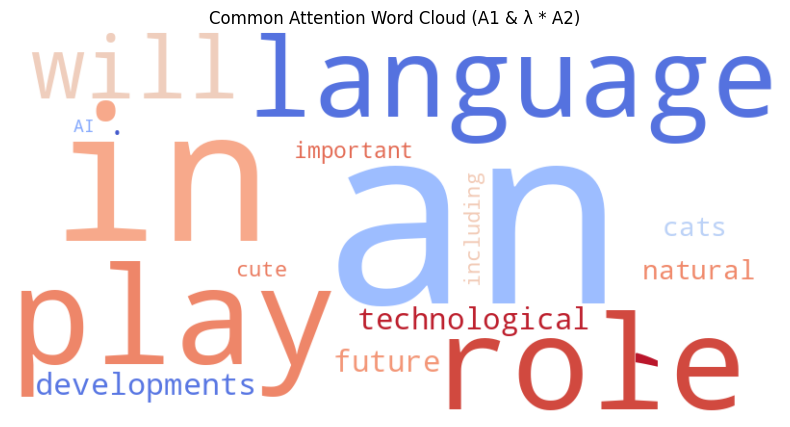

In [71]:
# サンプルテキストでWord Cloudを生成
sample_text = "AI will play an important role in future technological developments, including natural language. cute cats."
visualize_attention_with_model_lambda(weights_dir, model, tokenizer, sample_text, device)